In [1]:
import os,sys
sys.path.append('/home/ubuntu/hacking/projects/deep-mediation/deep-mediation/src')
import utils,build_model
import innvestigate
import numpy as np
from nilearn.image import load_img,mean_img
from keras.models import load_model
import nibabel as nib
import create_dataset,utils
import pandas as pd
from nilearn.image import resample_img,concat_imgs,load_img,resample_to_img,threshold_img,smooth_img
from nilearn.plotting import view_img
import keras

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/myclone/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/myclone/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/myclone/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anac

In [2]:
data_path = '/home/ubuntu/hacking/data/stephan-data-ni-files'
model_to_use = '/home/ubuntu/hacking/projects/deep-mediation/deep-mediation/results/deep/deep-iter-4-run-0.h5'
img_to_use = '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S860_OC1339_zs.nii'

In [3]:
dataset = create_dataset.generate_dataset(data_path,test_data_size=0.30)
train_rate,train_temp,train_imgs_list,flat_train_rate,flat_train_rate_zs = utils.get_rate_temp_img(dataset,subjs='train_subjs')
test_rate,test_temp,test_imgs_list,flat_test_rate,flat_test_rate_zs = utils.get_rate_temp_img(dataset,subjs='test_subjs')
# df_test = pd.DataFrame()
# df_test['X'] = test_temp
# df_test['Y'] = flat_test_rate_zs

These are the studies to use ['NSF', 'BMRK3', 'BMRK4', 'IE', 'ILCP', 'EXP', 'SCEBL']
This is the test study BMRK5 


In [4]:
train_imgs_list[0:5],test_imgs_list[0:5]

(['/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj1_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj2_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj3_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj4_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/NSF_data/nsf_subj5_zs.nii'],
 ['/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S850_OC1300_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S853_OC1307_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S860_OC1339_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S865_OC1328_zs.nii',
  '/home/ubuntu/hacking/data/stephan-data-ni-files/BMRK5_data/stim_bmrk5_S872_OC1337_zs.nii'])

In [5]:
# print("Reading training images...")
# train_imgs = utils.concat_imgs(train_imgs_list)
# print("Smoothing training images...")
# train_imgs = smooth_img(train_imgs, fwhm=[4,4,4]) #in mm 
# train_imgs = np.rollaxis(train_imgs.get_fdata(), 3, 0)[...,None]

print("Reading testing images...")
test_imgs = utils.concat_imgs(test_imgs_list)
print("Smoothing testing images...")
test_imgs = smooth_img(test_imgs, fwhm=[4,4,4]) #in mm 
test_imgs = np.rollaxis(test_imgs.get_fdata(), 3, 0)[...,None]

Reading testing images...
Smoothing testing images...


In [6]:
def get_model(model_to_use):
    model_with_gpu = load_model(model_to_use)
    model = model_with_gpu.layers[-2]
    return model
def get_nifti_params(input_img):
    affine = input_img.affine
    hdr = input_img.header
    return affine,hdr
def get_nifti_image(array,affine,header):
    nii_image = nib.Nifti1Image(array, affine, header)
    return nii_image

In [7]:
input_img = load_img(img_to_use)
affine,hdr = get_nifti_params(input_img)
input_img = input_img.get_fdata()
input_img = np.rollaxis(input_img, 3,0)[...,None]


In [8]:
model=get_model(model_to_use)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Allimages (InputLayer)          (None, 91, 109, 91,  0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 91, 109, 91,  224         Allimages[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 91, 109, 91,  32          conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 91, 109, 91,  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv3d_2 (

In [9]:
test_imgs.shape

(2596, 91, 109, 91, 1)

In [10]:
method = 'gradient'
analyzer = innvestigate.create_analyzer(method, model)
# analysis = []
# for i in range(test_imgs.shape[0]):
#     print(i)
#     analysis_value = analyzer.analyze(test_imgs[i:i+1,:,:,:])
#     analysis.append(analysis_value[0])
    
# analysis = np.array(analysis)
# print(analysis.shape)


In [11]:
test_imgs[0:50,:].shape

(50, 91, 109, 91, 1)

In [ ]:
analysis_value = analyzer.analyze(test_imgs[0:1,:])

In [ ]:
analysis_value.shape

In [ ]:
analysis_value[0,:,:,:,0].shape

In [ ]:
first_trial = get_nifti_image(test_imgs[0,:,:,:,0],affine,hdr)
first_trial_analyser = get_nifti_image(analysis_value[0,:,:,:,0],affine,hdr)

In [ ]:
view = view_img(first_trial)
view

In [ ]:
view = view_img(first_trial_analyser)
view

In [15]:
method = 'deep_taylor'
analyzer = innvestigate.create_analyzer(method, model)
analysis = []
for i in range(test_imgs.shape[0]1):
    print(i)
    analysis_value = analyzer.analyze(test_imgs[i:i+1,:,:,:])
    analysis.append(analysis_value[0])
    
analysis = np.array(analysis)
print(analysis.shape)

0
1
2
3
4
5
6
7
8
9
(10, 91, 109, 91, 1)


In [16]:
img = np.rollaxis(analysis, 0, 4)[:,:,:,:,0]
img.shape

(91, 109, 91, 10)

In [17]:
meanImg = mean_img(get_nifti_image(img,affine,hdr))
meanImg.shape

(91, 109, 91)

In [18]:
threshold_percentile_img = threshold_img(meanImg, threshold='97%', copy=False)

/home/ubuntu/anaconda3/envs/myclone/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval



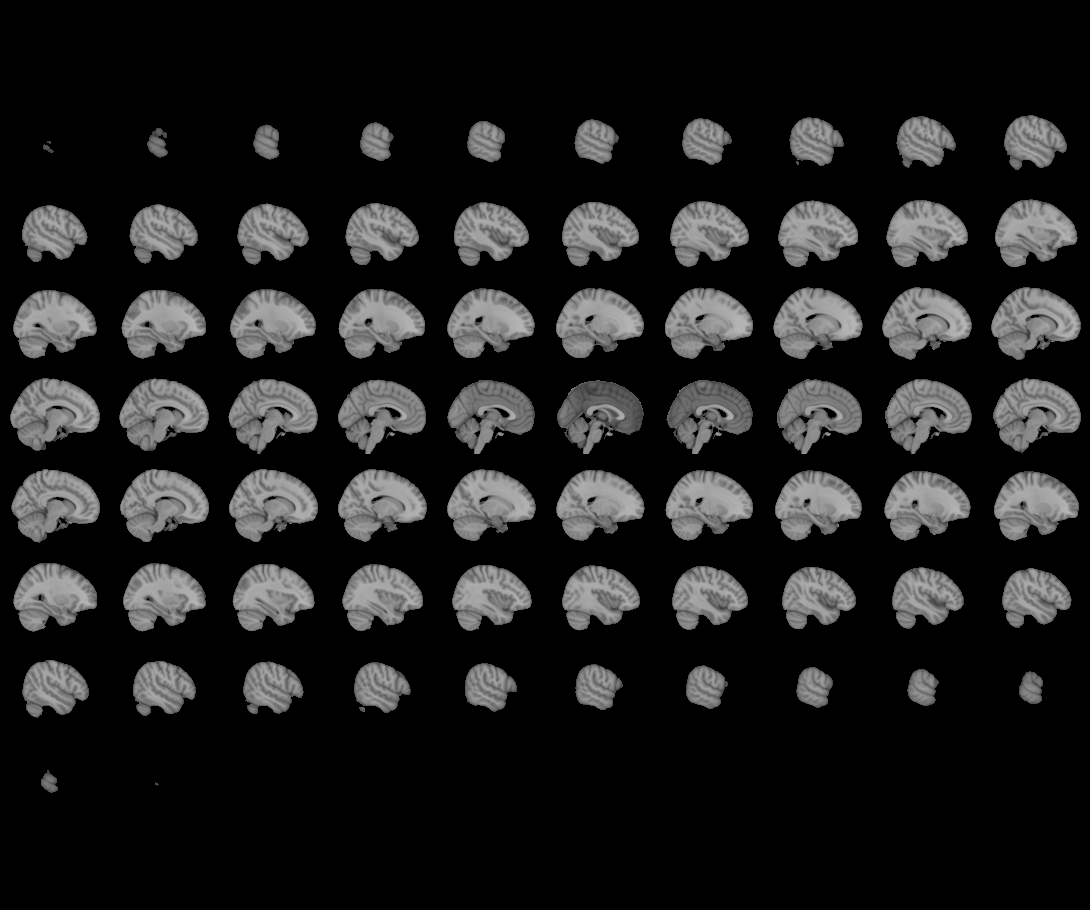
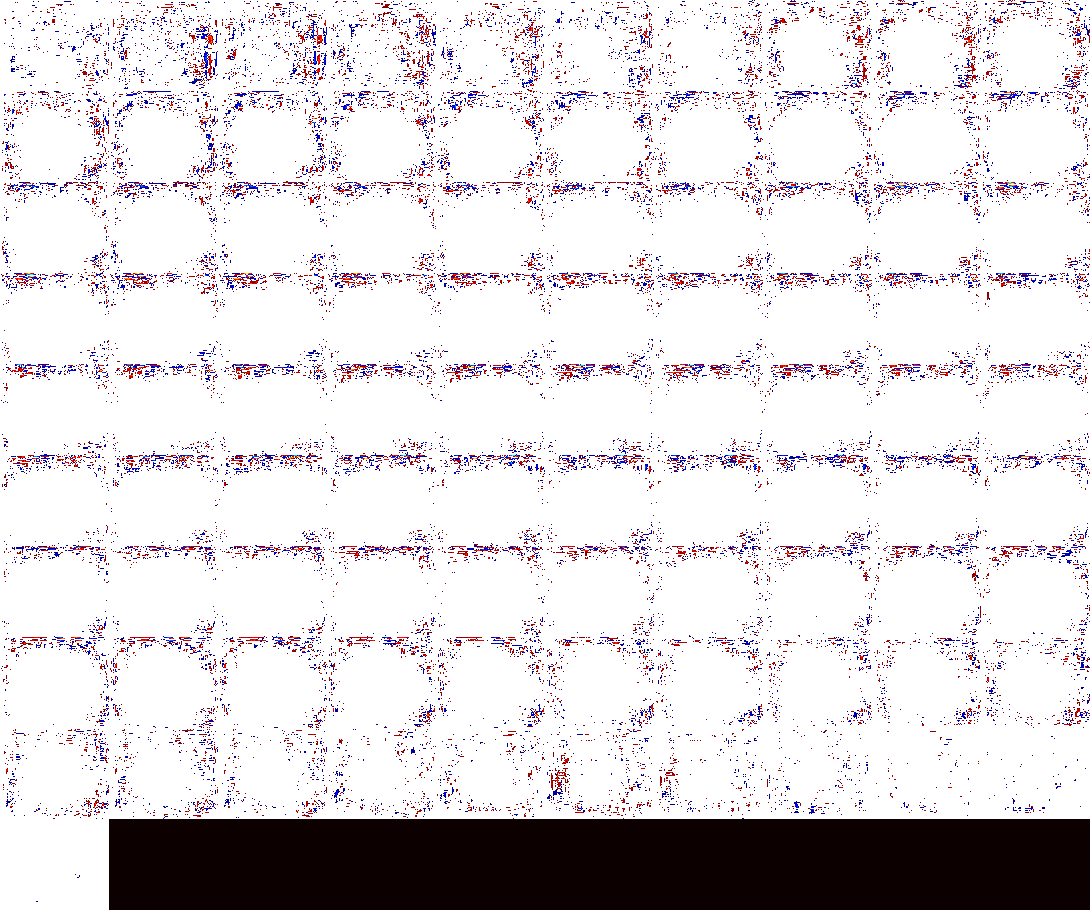

In [19]:
view = view_img(threshold_percentile_img)
view

### Try shapley values

In [10]:
import shap

In [11]:
def get_shap_values(model, background,test_data):
    explainer = shap.GradientExplainer(model, background,keras.backend.get_session())
    values = []
    for i in range(0,5): #test_data.shape[0]
        print(i)
        shap_values = explainer.shap_values(test_data[i:i+1,:])
#         shap_values = explainer.shap_values(test_data[i:i+1,:],check_additivity=False)
        values.append(shap_values[0])
    values_ = np.concatenate(values)
    return values_

In [12]:
num_imgs = 1

print("Using %s random images from training dataset as a background signal for Deep Shap..."%num_imgs)
random_train_imgs_list = np.array(train_imgs_list)[np.random.randint(0,146,num_imgs)]
random_train_imgs = utils.concat_images(list(random_train_imgs_list),None)
print(random_train_imgs.shape)


# background = utils.concat_images(list(train_imgs_list),None)
# background = np.rollaxis(background.get_fdata(), 3, 0)[...,None]
random_train_imgs = smooth_img(random_train_imgs, fwhm=[4,4,4]) #in mm 
background = np.rollaxis(random_train_imgs.get_fdata(), 3, 0)[...,None]

Using 1 random images from training dataset as a background signal for Deep Shap...
(91, 109, 91, 64)


In [13]:
background.shape,test_imgs.shape

((64, 91, 109, 91, 1), (2596, 91, 109, 91, 1))

In [ ]:
explainer = shap.GradientExplainer(model, background,keras.backend.get_session())
print("Computing shapley values...")
shap_values = explainer.shap_values(background[0:5])

Computing shapley values...


In [ ]:
values_ = get_shap_values(model, background,test_imgs)

0
1
2
3


In [ ]:
values_.shape

In [20]:
values_[:,:,:,:,0].shape

(10, 91, 109, 91)

In [22]:
img = np.rollaxis(values_, 0, 4)[:,:,:,:,0]
print(img.shape)
meanImg = mean_img(get_nifti_image(img,affine,hdr))
meanImg.shape

(91, 109, 91, 10)


(91, 109, 91)

In [23]:
threshold_first_trial_shapley = threshold_img(meanImg, threshold='97%', copy=False)

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



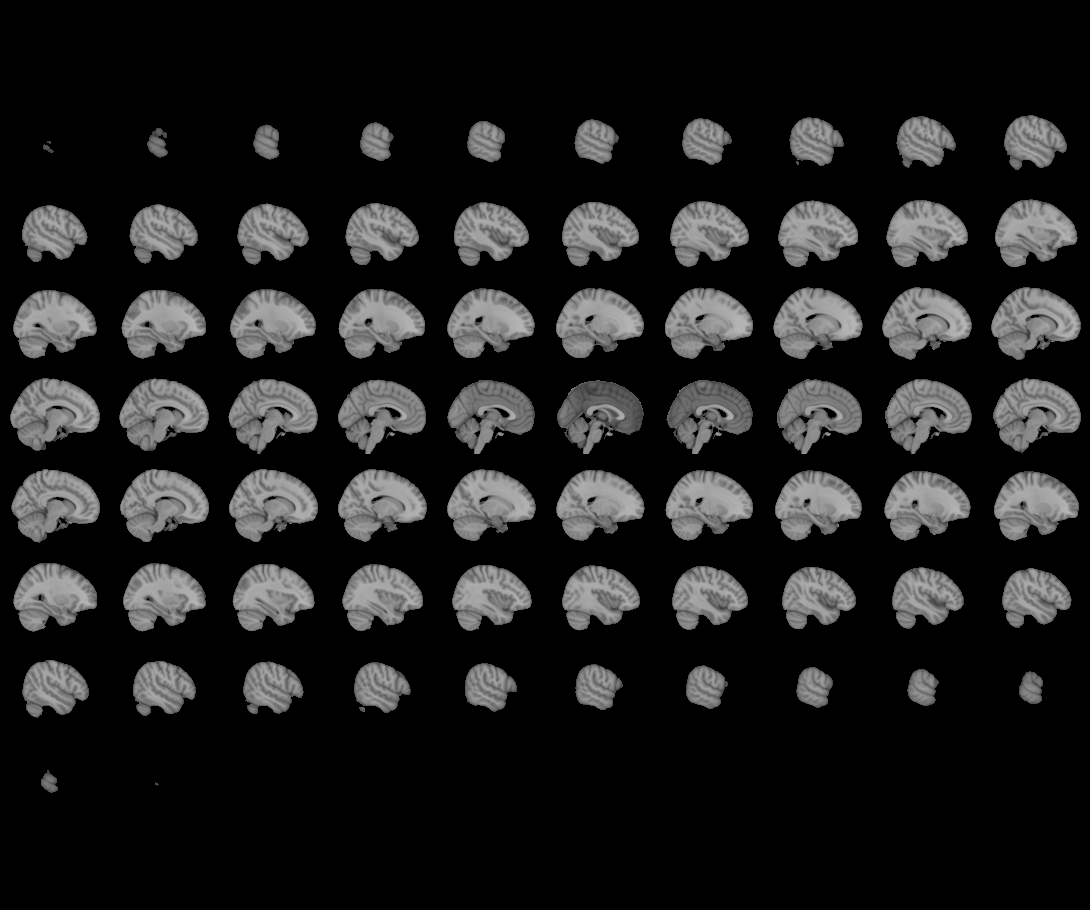
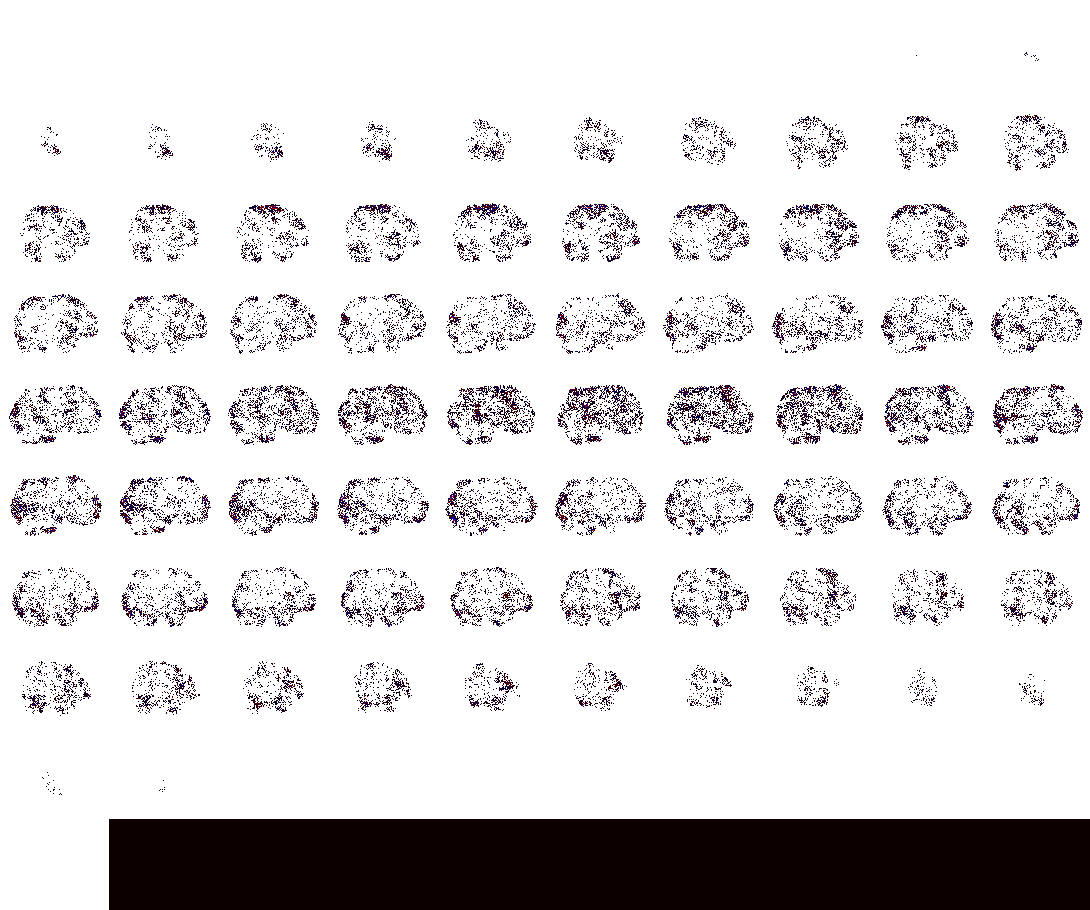

In [24]:
view = view_img(threshold_first_trial_shapley)
view

In [ ]:
# first_trial = get_nifti_image(values_[0,:,:,:,0],affine,hdr)
first_trial_shapley = get_nifti_image(values_[0,:,:,:,0],affine,hdr)

In [ ]:
threshold_first_trial_shapley = threshold_img(first_trial_shapley, threshold='97%', copy=False)

In [ ]:
first_trial_shapley.shape

In [ ]:
view = view_img(threshold_first_trial_shapley)
view

In [ ]:
test_imgs[0:1,:].shape

In [ ]:
values_ = get_shap_values(model, train_imgs,test_imgs)